# Detecção de fraude no e-commerce

### Bibliotecas básicas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import special
import itertools
from datetime import timedelta
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Carregamento dos dados

#### Compras

In [2]:
fraude_df = pd.read_csv('./datasets/Fraud_Data.csv', header=0)
print(f'Linhas: {fraude_df.shape[0]} | Colunas: {fraude_df.shape[1]}')
fraude_df.head()

Linhas: 151112 | Colunas: 11


,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


Tipos:

In [3]:
fraude_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

Valores nulos:

In [4]:
for col in fraude_df.columns:
    print('# de valores nulos em {}: {}'.format(col, fraude_df[col].isnull().sum()))

# de valores nulos em id: 0
# de valores nulos em cadastro: 0
# de valores nulos em compra: 0
# de valores nulos em valor: 0
# de valores nulos em id_dispositivo: 0
# de valores nulos em fonte: 0
# de valores nulos em browser: 0
# de valores nulos em genero: 0
# de valores nulos em idade: 0
# de valores nulos em ip: 0
# de valores nulos em fraude: 0


Resumo dos dados:

In [5]:
fraude_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


#### Escala de IPs de cada país

In [6]:
ISP_df = pd.read_csv('./datasets/IpAddress_to_Country.csv', header=0)
print(f'Linhas: {ISP_df.shape[0]} | Colunas: {ISP_df.shape[1]}')
ISP_df.head()

Linhas: 138846 | Colunas: 3


,limite_inferior_ip,limite_superior_ip,pais
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


Tipos:

In [7]:
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip      int64
pais                   object
dtype: object

In [8]:
ip_floats = ISP_df['limite_inferior_ip'].apply(lambda x : not x.is_integer()).sum()
print(f'Número de limites inferiores de IPs com decimal não-zero: {ip_floats}')

Número de limites inferiores de IPs com decimal não-zero: 0


In [9]:
ISP_df['limite_inferior_ip'] = ISP_df['limite_inferior_ip'].astype(int)
ISP_df.dtypes

limite_inferior_ip     int64
limite_superior_ip     int64
pais                  object
dtype: object

Valores nulos:

In [10]:
for col in ISP_df.columns:
    print('# de valores nulos em {}: {}'.format(col, ISP_df[col].isnull().sum()))

# de valores nulos em limite_inferior_ip: 0
# de valores nulos em limite_superior_ip: 0
# de valores nulos em pais: 0


Resumo dos dados:

In [11]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


Valores discrepantes:

In [12]:
display(ISP_df[ISP_df['limite_inferior_ip'] == ISP_df['limite_inferior_ip'].max()])
display(ISP_df[ISP_df['limite_superior_ip'] == ISP_df['limite_superior_ip'].max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


### Limpeza dos dados

In [14]:
def ip_para_pais(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)& (ISP_df.limite_superior_ip >= ip)]['pais']
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return 'Faltando'
    elif tmp.shape[0] > 1:
        return 'Erro'

fraude_df['pais'] = fraude_df['ip'].apply(ip_para_pais)

### Análise exploratória

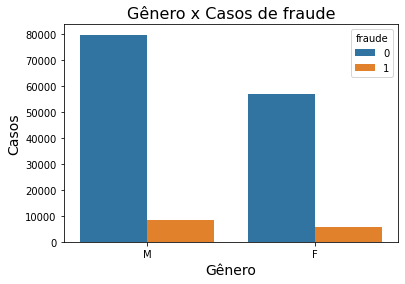

In [16]:
sns.countplot(x='genero', hue='fraude', data=fraude_df)
plt.xlabel('Gênero', fontsize=14)
plt.ylabel('Casos', fontsize=14)
plt.title('Gênero x Casos de fraude', fontsize=16)
plt.show()

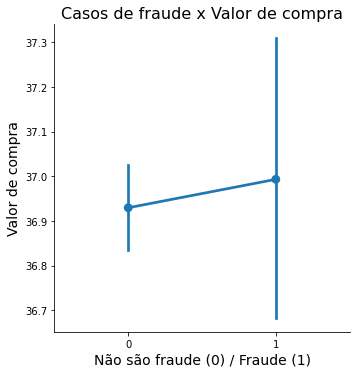

In [17]:
sns.factorplot(x='fraude', y='valor', data=fraude_df)
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Valor de compra', fontsize=14)
plt.title('Casos de fraude x Valor de compra', fontsize=16)
plt.show()

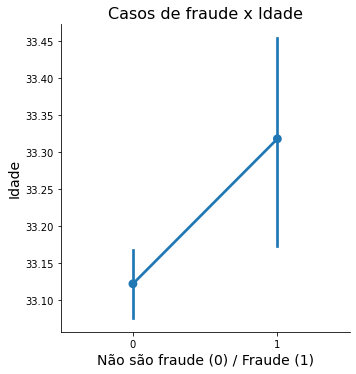

In [18]:
sns.factorplot(x='fraude', y='idade', data=fraude_df)
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Idade', fontsize=14)
plt.title('Casos de fraude x Idade', fontsize=16)
plt.show()

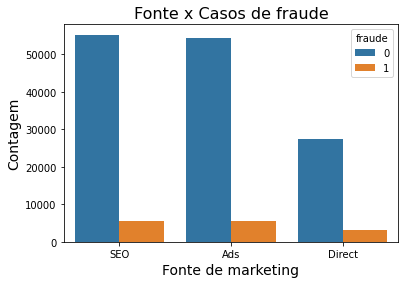

In [19]:
sns.countplot(x='fonte', hue='fraude', data=fraude_df)
plt.xlabel('Fonte de marketing', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Fonte x Casos de fraude', fontsize=16)
plt.show()

####  País de origem x Fraude

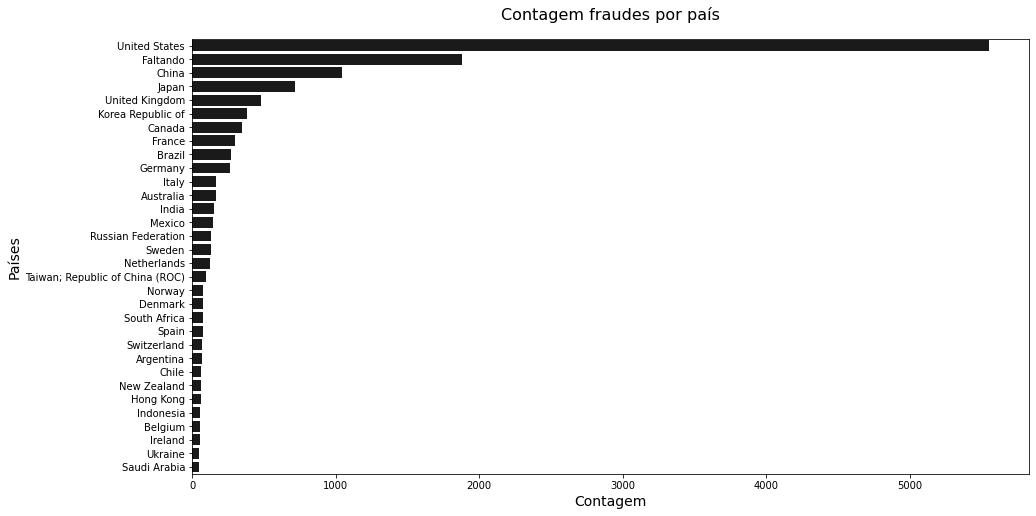

In [20]:
soma_fraudes_por_pais = fraude_df.query('fraude == 1')['fraude'].groupby(fraude_df['pais']).sum().reset_index()
soma_fraudes_por_pais = soma_fraudes_por_pais.sort_values('fraude', ascending=False)

f, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes('muted')
sns.barplot(x='fraude', y='pais', data=soma_fraudes_por_pais.query('fraude >= 50'), label='Total', color='k')
plt.xlabel('Contagem', fontsize=14)
plt.ylabel('Países', fontsize=14)
plt.title('Contagem fraudes por país', fontsize=16, y=1.03)
plt.show()

#### Número de IDs por cliente para cada dispositivo e para cada IP

In [21]:
tmp_df = pd.DataFrame(columns=('fraude', 'id_por_dispositivo', 'id_por_ip'))
tmp_df['fraude'] = fraude_df['fraude']

userid_count = fraude_df.groupby(by=['id_dispositivo']).id.count()
tmp_df['id_por_dispositivo'] = fraude_df['id_dispositivo'].apply(lambda x: userid_count[x])

userid_count2 = fraude_df.groupby(by=['ip']).id.count()
tmp_df['id_por_ip'] = fraude_df['ip'].apply(lambda x: userid_count2[x])

tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip
0,0,1,1
1,0,1,1
2,1,12,12
3,0,1,1
4,0,1,1


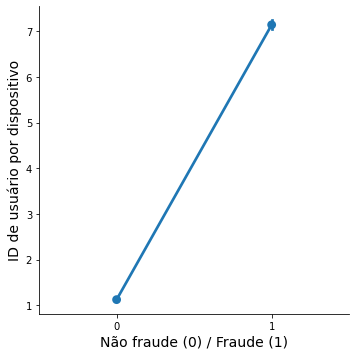

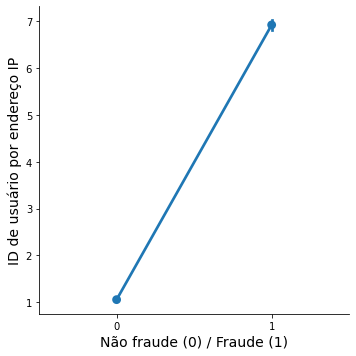

In [22]:
sns.factorplot(x='fraude', y='id_por_dispositivo', data=tmp_df)
plt.xlabel('Não fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('ID de usuário por dispositivo', fontsize=14)

sns.factorplot(x='fraude', y='id_por_ip', data=tmp_df)
plt.xlabel('Não fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('ID de usuário por endereço IP', fontsize=14)
plt.show()

#### Fraude x tempo de compra

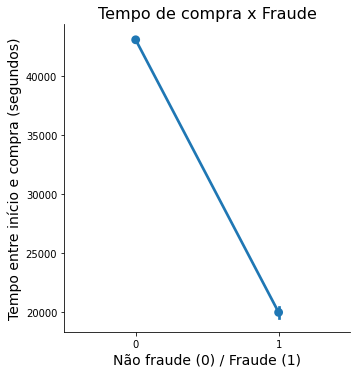

In [23]:
tmp_df['cadastro'] = fraude_df['cadastro'].apply(pd.to_datetime)
tmp_df['compra'] = fraude_df['compra'].apply(pd.to_datetime)
tmp_df['tempo'] = (tmp_df['compra'] - tmp_df['cadastro']).apply(lambda x: x.seconds)

sns.factorplot(x='fraude', y='tempo', data=tmp_df)
plt.xlabel('Não fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Tempo entre início e compra (segundos)', fontsize=14)
plt.title('Tempo de compra x Fraude', fontsize=16, y=1.03)
plt.show()

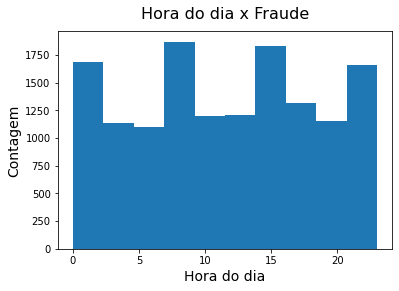

In [24]:
tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel('Hora do dia', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Hora do dia x Fraude', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

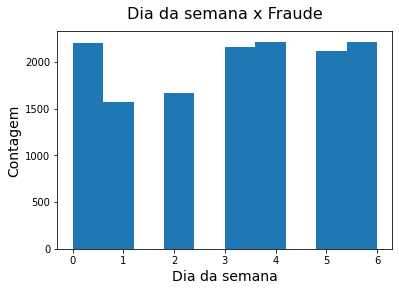

In [25]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel('Dia da semana', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Dia da semana x Fraude', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

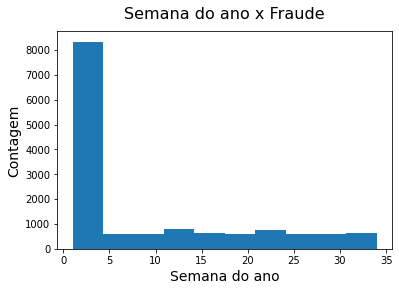

In [26]:
tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel('Semana do ano', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.title('Semana do ano x Fraude', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

### Engenharia de recursos

In [27]:
userid_count3 = fraude_df.groupby(by=['id_dispositivo']).id.count()
fraude_df['id_por_dispositivo'] = fraude_df['id_dispositivo'].apply(lambda x: userid_count3[x])

userid_count4 = fraude_df.groupby(by=['ip']).id.count()
fraude_df['id_por_ip'] = fraude_df['ip'].apply(lambda x: userid_count4[x])

fraude_df['media_id'] = (fraude_df['id_por_dispositivo'] + fraude_df['id_por_ip']) * 0.5

for col in ['cadastro', 'compra']:
    fraude_df[col] = fraude_df[col].apply(pd.to_datetime)
    
fraude_df['tempo'] = (fraude_df['compra'] - fraude_df['cadastro']).apply(lambda x: x.seconds)
fraude_df.head(2)

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944


In [28]:
pais_dummies = pd.get_dummies(fraude_df['pais'], prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)

fraude_df.drop(['id', 'cadastro', 'compra', 'id_dispositivo', 'ip', 'id_por_dispositivo', 'id_por_ip', 'pais', 'fonte', 'browser', 
                'genero', 'idade', 'valor'], axis=1, inplace=True)
fraude_df.head()

,fraude,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0,1.0,13882,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.0,17944,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,12.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1.0,60085,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,41461,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Seleção de recursos

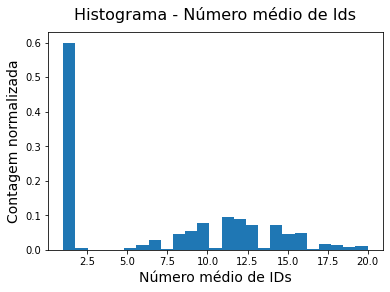

In [29]:
fraude_df[fraude_df['fraude'] == 1].media_id.hist(density=True, bins=25)
plt.xlabel('Número médio de IDs', fontsize=14)
plt.ylabel('Contagem normalizada', fontsize=14)
plt.title('Histograma - Número médio de Ids', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

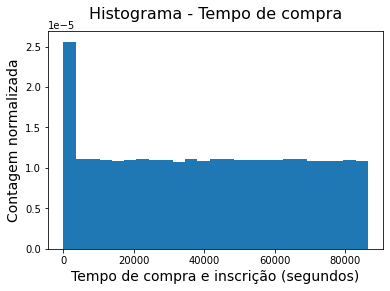

In [30]:
fraude_df['tempo'].hist(density=True, bins=25)
plt.xlabel('Tempo de compra e inscrição (segundos)', fontsize=14)
plt.ylabel('Contagem normalizada', fontsize=14)
plt.title('Histograma - Tempo de compra', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

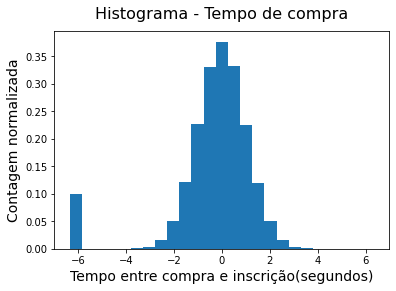

In [31]:
def rescale_series(serie):
    serie_min = serie.min() - 1e-5
    serie_max = serie.max() + 1e-5
    new_serie = (serie - serie_min) / (serie_max - serie_min)
    new_serie = new_serie.apply(lambda x: np.sqrt(2)*special.erfinv(2*x - 1))
    return new_serie

fraude_df['tempo'] = rescale_series(fraude_df['tempo'])
fraude_df['tempo'].hist(density=True, bins=25)
plt.xlabel('Tempo entre compra e inscrição(segundos)', fontsize=14)
plt.ylabel('Contagem normalizada', fontsize=14)
plt.title('Histograma - Tempo de compra', fontsize=16, y=1.03)
plt.grid(False)
plt.show()

Identificando variáveis importantes

In [32]:
def rescale_series(serie):
    return (serie - serie.min()) / (serie.max() - serie.min())

one_hot_encoded = [feature for feature in fraude_df.columns if 'pais' not in feature and feature != 'fraude']

for col in one_hot_encoded:
    fraude_df[col] = rescale_series(fraude_df[col])

X = fraude_df[[col for col in fraude_df.columns if col != 'fraude']]
Y = fraude_df['fraude']

In [33]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
_ = clf.fit(X, Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_
features [features['importancia'] > np.mean(features['importancia'])].sort_values(by='importancia', ascending=False)

,feature,importancia
1,tempo,0.685177
0,media_id,0.309389


### Modelo supervisionado

In [34]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=23)
y_train = y_train.apply(lambda x: 1 if x == 0 else -1)
y_test = y_test.apply(lambda x: 1 if x == 0 else -1)

# clf_if = IsolationForest(max_samples='auto', contamination=0.095, random_state=1)
# param_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500]}
# clf = GridSearchCV(clf_if, param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=2)
# _ = clf.fit(X_train, y_train)

clf.best_estimator_ = IsolationForest(contamination=0.095, n_estimators=500, random_state=1)

In [36]:
clf_if_best = IsolationForest(contamination=0.095, n_estimators=500, random_state=1)
_ = clf_if_best.fit(X_train, y_train)

y_pred = clf_if_best.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print('Área sob a curva ROC: {:0, 3f}', format(roc_auc))
print (classification_report(y_test, y_pred, target_names=['anômalo', 'normal']))

Área sob a curva ROC: {:0, 3f} 0.7382974055009928
              precision    recall  f1-score   support

     anômalo       0.52      0.53      0.52      3546
      normal       0.95      0.95      0.95     34232

    accuracy                           0.91     37778
   macro avg       0.74      0.74      0.74     37778
weighted avg       0.91      0.91      0.91     37778



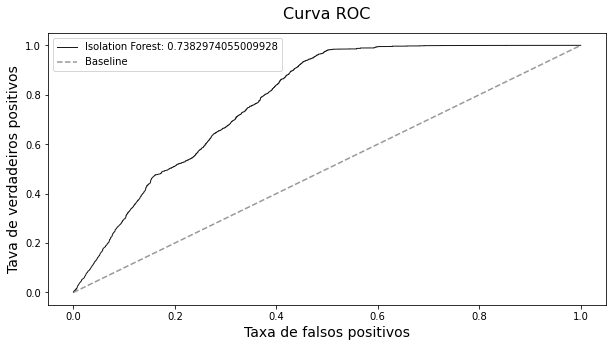

In [37]:
if_probs = clf_if_best.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, if_probs)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, lw=1, label=f'Isolation Forest: {roc_auc}', color='k')
plt.plot([0,1],[0,1], '--', color=(0.6,0.6,0.6), label='Baseline')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de falsos positivos', fontsize=14)
plt.ylabel('Tava de verdadeiros positivos', fontsize=14)
plt.title('Curva ROC', fontsize=16, y=1.03)
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[ 1866  1680]
 [ 1699 32533]]


### Modelo não supervisionado

In [39]:
import random

X['fraude'] = Y
X_anomalias = X[X['fraude'] == 1]
X_normal = X[X['fraude'] == 0]

train_idxs = random.sample(list(X_normal.index), int(0.7*X_normal.shape[0]))
X_train_NSuper = X_normal.loc[train_idxs]

X_testing = X_normal.drop(train_idxs)
X_testing = pd.concat([X_testing, X_anomalias], axis=0)

X_train_NSuper = X_train_NSuper.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

Y_testing = X_testing['fraude']
X_testing = X_testing [[col for col in X_testing.columns if col != 'fraude']]

X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size=0.7, random_state=23)
Y_cv = Y_cv.apply(lambda x: 1 if x==0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x==0 else -1)

X_train = X_train[[col for col in X_testing.columns if col != 'fraude']]

In [40]:
from sklearn.svm import OneClassSVM

param_grid = {'nu': np.linspace(0.001, 0.01, 5), 'gamma': [0.01, 0.03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid['nu'], param_grid['gamma']))


def random_gridsearch(param_list, n_sample, X_train_NSuper, X_cv, Y_cv):
    f1_max = 0
    param_list = random.sample(param_list, n_sample)
    remaining_fits = n_sample
    
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        print('Fitando modelo...')
        OCSVM.fit(X_train_NSuper)

        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average='binary')

        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM
            remaining_fits -=1
    return f1_max, OCSVM

f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...


In [41]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)
print('Área sob a curva ROC: {:0.3f}', format(roc_auc))
print(classification_report(Y_eval, Y_predicted, target_names=['anormais', 'normais']))

Área sob a curva ROC: {:0.3f} 0.5114595334255904
              precision    recall  f1-score   support

    anormais       0.71      0.03      0.05      4228
     normais       0.75      1.00      0.86     12344

    accuracy                           0.75     16572
   macro avg       0.73      0.51      0.45     16572
weighted avg       0.74      0.75      0.65     16572



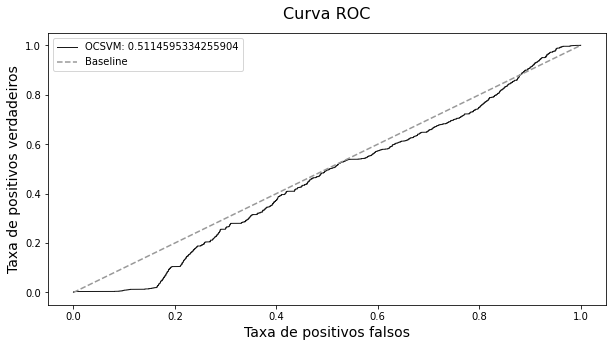

In [42]:
OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, threshold = roc_curve(Y_eval, OCSVM_probs)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, lw=1, label=f'OCSVM: {roc_auc}', color='k')
plt.plot([0,1], [0,1], '--', color=[0.6, 0.6, 0.6], label='Baseline')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=14)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=14)
plt.title('Curva ROC', fontsize=16, y=1.03)
plt.legend()
plt.show()

In [43]:
print(confusion_matrix(Y_eval, Y_predicted))

[[  113  4115]
 [   47 12297]]


### Melhorando o modelo

In [44]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, y_train)
y_predicted = decision_tree.predict(X_test)
roc_auc = roc_auc_score(y_test, y_predicted)
print('Área sob a curva ROC: {:0.3f}', format(roc_auc))
print(classification_report(y_test, y_predicted, target_names=['anormais', 'normais']))

Área sob a curva ROC: {:0.3f} 0.7613002027108875
              precision    recall  f1-score   support

    anormais       0.58      0.57      0.57      3546
     normais       0.96      0.96      0.96     34232

    accuracy                           0.92     37778
   macro avg       0.77      0.76      0.76     37778
weighted avg       0.92      0.92      0.92     37778



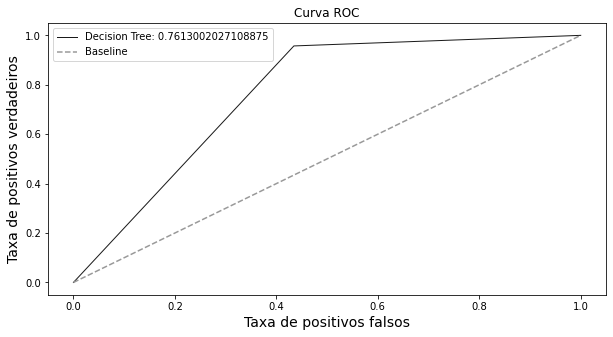

In [45]:
dt_probs = decision_tree.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_predicted)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, lw=1, label=f'Decision Tree: {roc_auc}', color='k')
plt.plot([0,1], [0,1], '--', color=[0.6, 0.6, 0.6], label='Baseline')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taxa de positivos falsos', fontsize=14)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=14)
plt.title('Curva ROC')
plt.legend()
plt.show()

In [46]:
print(confusion_matrix(y_test, y_predicted))

[[ 2005  1541]
 [ 1466 32766]]
